In [2]:
import os
import sys
sys.path.append("/home/ubuntu/workspace/code/compositional-representation-learning")

import yaml
import pickle

import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt

from pl_modules import PatchBoxEmbeddingsVAE
from datasets import get_dataset

AllenNLP not available. Registrable won't work.


In [8]:
config_filepath = "/home/ubuntu/workspace/code/compositional-representation-learning/configs/PatchBoxEmbeddingsVAE/PatchBoxEmbeddingsVAE_exp_0.yaml"
checkpoint_filepath = "/home/ubuntu/workspace/experiment_root_dir/PatchBoxEmbeddingsVAE_exp_0/PatchBoxEmbeddingsVAE_exp_0___2025-11-07__10-50-46/checkpoints/model-epoch=099.ckpt"

with open(config_filepath, "r") as file_handle:
    config = yaml.safe_load(file_handle)

model = PatchBoxEmbeddingsVAE.load_from_checkpoint(checkpoint_filepath, config=config)
model.eval()

PatchBoxEmbeddingsVAE(
  (vae): VanillaVAE(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (2): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (3): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [4]:
dataset = get_dataset(config)

Running inference on sample 42...
Inference complete.
Generating plot...


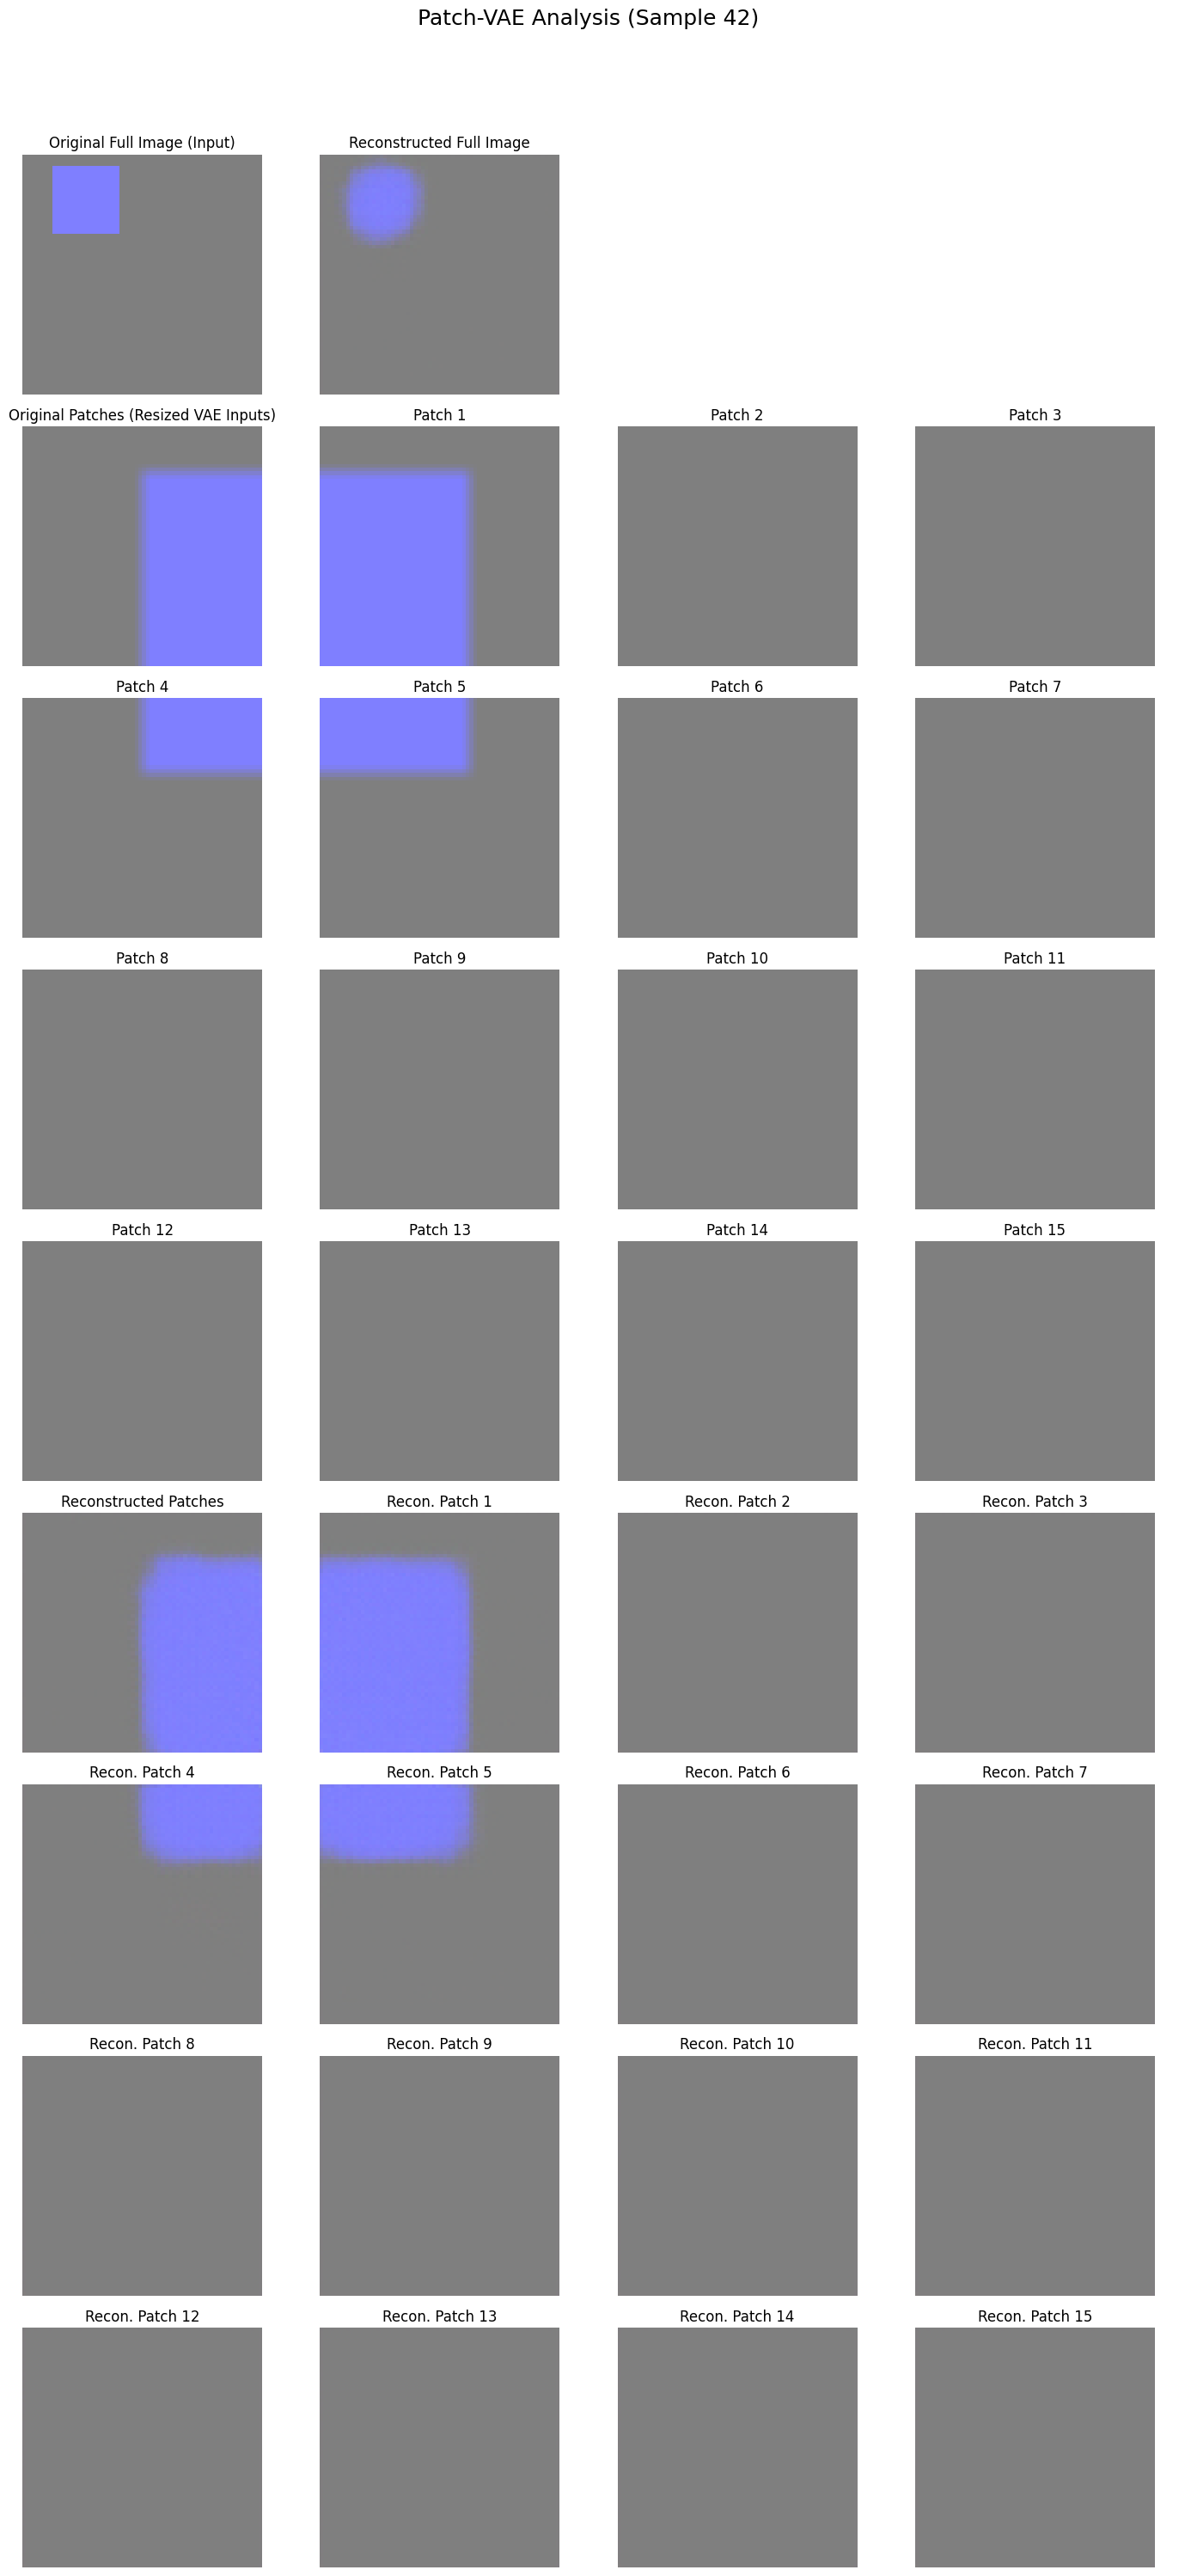

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Helper function to display images ---
def tensor_to_img(tensor):
    """
    Converts a (C, H, W) tensor to (H, W, C) numpy array 
    and denormalizes from [-1, 1] (from nn.Tanh) to [0, 1] for plotting.
    """
    # Detach from graph, move to CPU, change from (C,H,W) to (H,W,C)
    img = tensor.detach().cpu().permute(1, 2, 0).numpy()
    
    # Denormalize from [-1, 1] to [0, 1]
    img = (img * 0.5) + 0.5
    
    # Clip values to be safe
    return np.clip(img, 0, 1)

# --- 2. Get a single sample ---
# We assume 'dataset' is a dictionary containing 'train', 'val', etc.
# If 'val' doesn't exist, we'll try 'test' or just use 'dataset' itself.
# try:
#     val_dataset = dataset['val']
#     print("Using 'val' dataset.")
# except (KeyError, TypeError):
#     try:
#         val_dataset = dataset['test']
#         print("Using 'test' dataset.")
#     except (KeyError, TypeError):
#         print("Could not find 'val' or 'test' key, assuming `dataset` is the validation dataset itself.")
#         val_dataset = dataset

# Pick any sample you want to visualize
sample_idx = 42 
sample = dataset[sample_idx]

# --- 3. Prepare batch and move to device ---
device = model.device

# Create a batch of size 1 and move all tensors to the model's device
batch = {}
for k, v in sample.items():
    if isinstance(v, torch.Tensor):
        batch[k] = v.unsqueeze(0).to(device)
    else:
        batch[k] = v # Keep other non-tensor data

# --- 4. Forward pass ---
print(f"Running inference on sample {sample_idx}...")
with torch.no_grad(): # Disable gradient calculations
    outputs = model(batch)
print("Inference complete.")

# --- 5. Extract all necessary tensors ---
grid_h, grid_w = model.grid_size
num_patches = grid_h * grid_w

# 'outputs["images"]' contains the VAE's inputs (resized patches + full image)
# 'outputs["reconstructed_images"]' contains the VAE's outputs
all_vae_inputs = outputs["images"].squeeze(0).cpu()
all_reconstructions = outputs["reconstructed_images"].squeeze(0).cpu()

# The last item is the full image
original_full_image = all_vae_inputs[-1]
reconstructed_full_image = all_reconstructions[-1]

# The first 'num_patches' items are the (resized) patches
original_patches = all_vae_inputs[:-1] 
reconstructed_patches = all_reconstructions[:-1]

if original_patches.shape[0] != num_patches:
    print(f"Warning: Number of patches in output ({original_patches.shape[0]}) does not match grid size ({num_patches}). Check config.")

# --- 6. Visualization ---
print("Generating plot...")

# We need 1 row for full images, grid_h rows for orig patches, grid_h rows for recon patches
total_rows = 1 + 2 * grid_h
fig, axes = plt.subplots(total_rows, grid_w, figsize=(grid_w * 3.5, total_rows * 3.5))

# --- Handle edge cases for plt.subplots() return type ---
# This ensures 'axes' is always a 2D numpy array for consistent indexing
if total_rows == 1 and grid_w == 1:
    axes = np.array([[axes]]) # Single Axes object
elif total_rows == 1:
    axes = axes.reshape(1, -1) # 1D array (row)
elif grid_w == 1:
    axes = axes.reshape(-1, 1) # 1D array (column)
# 2D array case is default

fig.suptitle(f"Patch-VAE Analysis (Sample {sample_idx})", fontsize=18)

# --- Row 0: Full Images ---
axes[0, 0].imshow(tensor_to_img(original_full_image))
axes[0, 0].set_title("Original Full Image (Input)")
axes[0, 0].axis('off')

axes[0, 1].imshow(tensor_to_img(reconstructed_full_image))
axes[0, 1].set_title("Reconstructed Full Image")
axes[0, 1].axis('off')

# Hide other axes in the first row if grid_w > 2
for j in range(2, grid_w):
    axes[0, j].axis('off')

# --- Rows 1 to grid_h: Original Patches (Resized VAE Inputs) ---
for i in range(grid_h):
    for j in range(grid_w):
        patch_idx = i * grid_w + j
        if patch_idx >= len(original_patches): continue # Safety check
        
        ax = axes[1 + i, j]
        ax.imshow(tensor_to_img(original_patches[patch_idx]))
        ax.axis('off')
        
        # Add a section title to the first patch
        if i == 0 and j == 0:
            ax.set_title("Original Patches (Resized VAE Inputs)")
        else:
            ax.set_title(f"Patch {patch_idx}")
            
# --- Rows grid_h+1 to 2*grid_h: Reconstructed Patches ---
for i in range(grid_h):
    for j in range(grid_w):
        patch_idx = i * grid_w + j
        if patch_idx >= len(reconstructed_patches): continue # Safety check
            
        ax = axes[1 + grid_h + i, j]
        ax.imshow(tensor_to_img(reconstructed_patches[patch_idx]))
        ax.axis('off')

        # Add a section title to the first patch
        if i == 0 and j == 0:
            ax.set_title("Reconstructed Patches")
        else:
            ax.set_title(f"Recon. Patch {patch_idx}")

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for suptitle
plt.show()